In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import csv
import os
from tensorboardX import SummaryWriter

from tqdm import tqdm_notebook as tqdm

from data.data import DeClareDataset
from model.deClare import DeClareModel

In [2]:
torch.cuda.is_available()

True

# Load Datasets

In [3]:
SNOPES_LOC = "./Datasets/Snopes/snopes.tsv"
#consists of rumors analyzed on the Snopes website along with their credibility labels (true or false), 
#sets of reporting articles, and their respective web sources

POLITIFACT_LOC = "./Datasets/PolitiFact/politifact.tsv"

glove_data_file = "./Glove/glove.6B.100d.txt"

In [4]:
snopes = DeClareDataset(SNOPES_LOC, glove_data_file)

Successfully read news data from ./Datasets/Snopes/snopes.tsv
Number of articles = 29242
Number of claims = 4341
Using pre-built vocabulary


In [5]:
snopes.news_df.head()

,Credibility,Claim_Source,Claim,Article,Article_Source
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net


## Preliminary Analysis

In [6]:
batch_size = 32
nb_lstm_units = 64

In [7]:
dataloader = DataLoader(snopes, batch_size, shuffle=True)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
declare = DeClareModel(snopes.initial_embeddings, snopes.claim_source_vocab_size, 
                       snopes.article_source_vocab_size, nb_lstm_units, device)

declare.to(device)

DeClareModel(
  (word_embeddings): Embedding(56755, 100)
  (claim_source_embeddings): Embedding(4342, 4)
  (article_source_embeddings): Embedding(12237, 8)
  (attention_dense): Linear(in_features=200, out_features=1, bias=True)
  (attention_dropout): Dropout(p=0.5)
  (dense_1): Linear(in_features=140, out_features=64, bias=True)
  (dense_1_dropout): Dropout(p=0.5)
  (dense_2): Linear(in_features=64, out_features=64, bias=True)
  (dense_2_dropout): Dropout(p=0.5)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (biLSTM): LSTM(100, 64, batch_first=True, bidirectional=True)
)

In [10]:
optimizer = optim.Adam(declare.parameters(), lr=0.002)
BCEloss = nn.BCELoss()

In [11]:
losses = {}
num_epochs = 15
reg_lambda = 0.0

writer = SummaryWriter()

for epoch in range(num_epochs):
    losses[epoch] = []
    for data_sample in tqdm(dataloader):
        declare.zero_grad()
        idx = np.argsort(-data_sample[3])
        
        for i in range(len(data_sample)):
            data_sample[i] = data_sample[i][idx].to(device)

        out = declare(data_sample[0], data_sample[1], data_sample[2], data_sample[3], data_sample[4], data_sample[5])
        loss = BCEloss(out, data_sample[6].float())

        l2_reg = None
        for param in declare.named_parameters():
            if 'dense' in param[0] and 'weight' in param[0]:
                if l2_reg is None:
                    l2_reg = param[1].norm(2)
                else:
                    l2_reg = l2_reg + param[1].norm(2)

        total_loss = loss + reg_lambda*l2_reg
        writer.add_scalar('total loss', total_loss, epoch)
        writer.add_scalar('regularization loss', l2_reg, epoch)
        writer.add_scalar('loss', loss, epoch)
        writer.add_scalar('pad embedding', declare.word_embeddings(torch.tensor([0]).to(device)).data.mean())
        
        
        losses[epoch].append(total_loss.data)

        total_loss.backward()
        optimizer.step()

/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


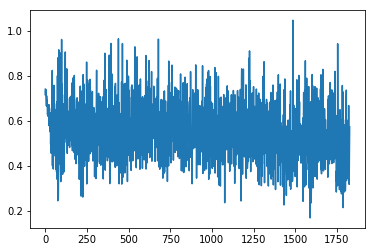

In [12]:
plt.plot(losses[0])